# US Federal Public Debt Holders
This notebook looks at the evolution of the ownership structure of US Federal Public Debt. I make use of data series with quarterly frequencies provided by [FRED](https://fred.stlouisfed.org).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1969-01-01')
report_end = date.today()

In [3]:
# Human readable column names for DataFrames
FEDERAL_DEBT_TOTAL = 'Total Federal Debt'
FEDERAL_DEBT_HELD_BY_PUBLIC = 'Federal Debt Held by the Public'
FEDERAL_DEBT_HELD_BY_US_GOVERNMENT = 'Federal Debt Held by US Government'
FEDERAL_DEBT_HELD_BY_FED = 'Federal Debt Held by FED'
FEDERAL_DEBT_HELD_BY_FOREIGN = 'Federal Debt Held by Foreign and International Investors'
FEDERAL_DEBT_HELD_BY_DOMESTIC = 'Federal Debt Held by Domestic Owners'

### Federal Debt Holders, preparation of data
There are five relevant dataseries provided by [FRED](https://fred.stlouisfed.org) that could potentially be used:
* `GFDEBTN` &mdash; Federal Debt: Total Public Debt in millions (quarterly frequency). This series accounts for both federal debt held by the public as well as US intragovernmental debt.
* `FYGFDPUN` &mdash; unlike `GFDEBTN` this series accounts only for federal debt held by the public in millions (quarterly frequency).
* `FDHBATN` &mdash; The US intragovernmental part of the debt in millions (quarterly frequency).
* `FDHBFRBN` &mdash; Federal Debt Held by Federal Reserve Banks in billions (quarterly frequency).
* `FDHBFIN` &mdash; Federal Debt Held by Foreign and International Investors in billions (quarterly frequency)

The following relationships hold:
* `GFDEBTN` = `FYGFDPUN` + `FDHBATN`
* US Domestic ownership = `FYGFDPUN` - `FDHBFRBN` - `FDHBFIN`

In [4]:
# GFDEBTN   -- Federal Debt: Total Public Debt in millions (quarterly frequency)
# FYGFDPUN  -- Federal Debt Held by the Public in millions (quarterly frequency)
# FDHBATN   -- Federal Debt Held by Agencies and Trusts in millions (quarterly frequency)
# GFDEBTN = FYGFDPUN + FDHBATN

# FDHBFRBN  -- Federal Debt Held by Federal Reserve Banks in billions (quarterly frequency)
# FDHBFIN   -- Federal Debt Held by Foreign and International Investors in billions (quarterly frequency)
# FYGFDPUN = FDHBFRBN + FDHBFIN + Domestic holdings

fred_pub_debt_holders = web.get_data_fred(['GFDEBTN', 'FYGFDPUN', 'FDHBATN', 'FDHBFRBN', 'FDHBFIN'],
                                          start=report_start, end=report_end)

# Convert all amounts into millions
fred_pub_debt_holders[['FDHBFRBN', 'FDHBFIN']] *= 1000

# Adding as a new column for the domestic part
fred_pub_debt_holders[FEDERAL_DEBT_HELD_BY_DOMESTIC] = fred_pub_debt_holders.FYGFDPUN\
        - fred_pub_debt_holders.FDHBFRBN - fred_pub_debt_holders.FDHBFIN
    
# Truncating to the earliest quarter where all dataseries have data
fred_pub_debt_holders.dropna(inplace=True)

### Visualization of prepared data

In [5]:
fred_pub_debt_holders.rename(
    columns={'GFDEBTN': FEDERAL_DEBT_TOTAL,
             'FYGFDPUN': FEDERAL_DEBT_HELD_BY_PUBLIC, 'FDHBATN': FEDERAL_DEBT_HELD_BY_US_GOVERNMENT,
             'FDHBFRBN': FEDERAL_DEBT_HELD_BY_FED, 'FDHBFIN': FEDERAL_DEBT_HELD_BY_FOREIGN},
    inplace=True)
IDX_FORMAT = '{:%Y-%m}'

In [6]:
fred_pub_debt_holders
# The last 4 years
fred_pub_debt_holders.tail(16).style.format_index(IDX_FORMAT).format('{:,.0f}M').set_table_styles(
    [{'selector':'.index_name.level0', 'props': [('min-width', '78px')]},
     {'selector':'.col0', 'props': [('min-width', '110px')]}])

,Total Federal Debt,Federal Debt Held by the Public,Federal Debt Held by US Government,Federal Debt Held by FED,Federal Debt Held by Foreign and International Investors,Federal Debt Held by Domestic Owners
DATE,,,,,,
2019-01,"22,027,880M","16,223,851M","5,804,029M","2,536,673M","6,474,000M","7,213,178M"
2019-04,"22,023,283M","16,204,719M","5,818,564M","2,452,784M","6,625,900M","7,126,035M"
2019-07,"22,719,402M","16,825,978M","5,893,424M","2,436,438M","6,923,500M","7,466,040M"
2019-10,"23,201,380M","17,187,392M","6,013,988M","2,637,320M","6,844,200M","7,705,872M"
2020-01,"23,223,813M","17,228,778M","5,995,035M","3,559,553M","6,949,500M","6,719,725M"
2020-04,"26,477,241M","20,548,375M","5,928,866M","4,615,353M","7,052,100M","8,880,922M"
2020-07,"26,945,391M","21,037,627M","5,907,764M","4,872,973M","7,069,200M","9,095,454M"
2020-10,"27,747,798M","21,651,416M","6,096,382M","5,127,835M","7,070,700M","9,452,881M"
2021-01,"28,132,570M","22,006,863M","6,125,707M","5,401,362M","7,038,300M","9,567,201M"


In [7]:
FED_DEBT_HOLDERS_TITLE = 'US Federal Debt Holders and Their Amounts'
FED_DEBT_HOLDERS_PERCENTAGE_TITLE = 'US Federal Debt Holders and Their Ownership'
LEFT_Y_AXIS_LABEL = 'Billions of USD'

#### Displaying each holding independently

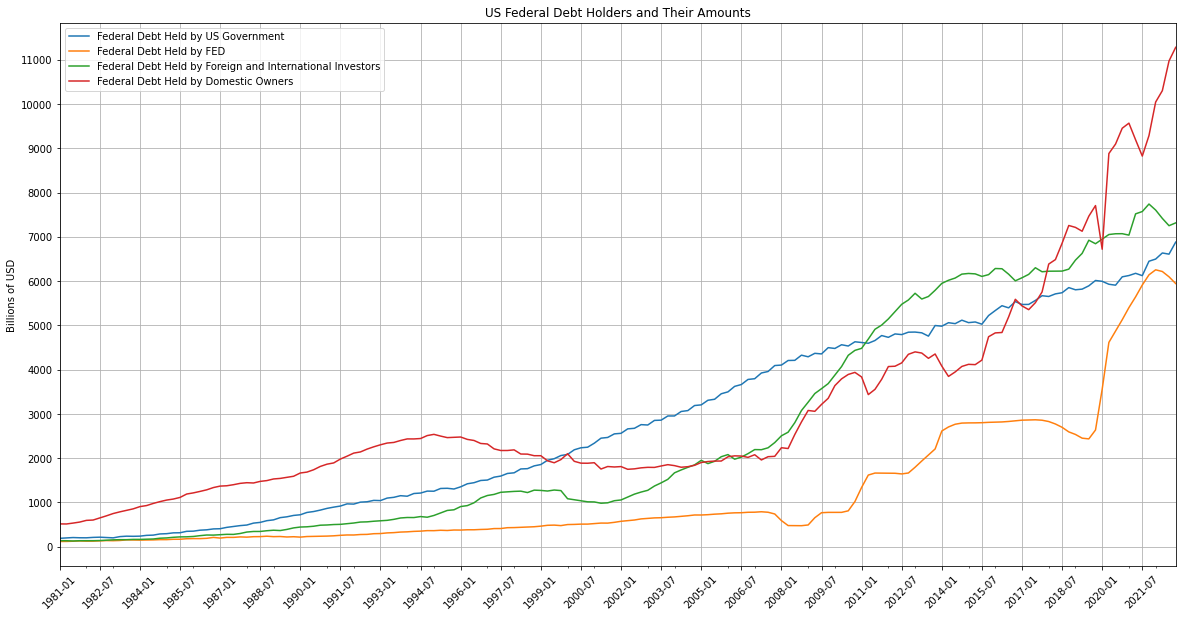

In [8]:
smaller_df = fred_pub_debt_holders[[FEDERAL_DEBT_HELD_BY_US_GOVERNMENT, FEDERAL_DEBT_HELD_BY_FED,
                                   FEDERAL_DEBT_HELD_BY_FOREIGN, FEDERAL_DEBT_HELD_BY_DOMESTIC]]
ax = smaller_df.plot(figsize=(20,10), grid=True, title=FED_DEBT_HOLDERS_TITLE,
                     xticks=fred_pub_debt_holders.index[::6], xlabel='', rot=45,
                     ylabel=LEFT_Y_AXIS_LABEL, yticks=np.arange(0, 12000e3, 1000e3))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: "%.0f" % (x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, fred_pub_debt_holders.index[::6])))

#### Stacked Visualization Amounting to Total US Federal Debt

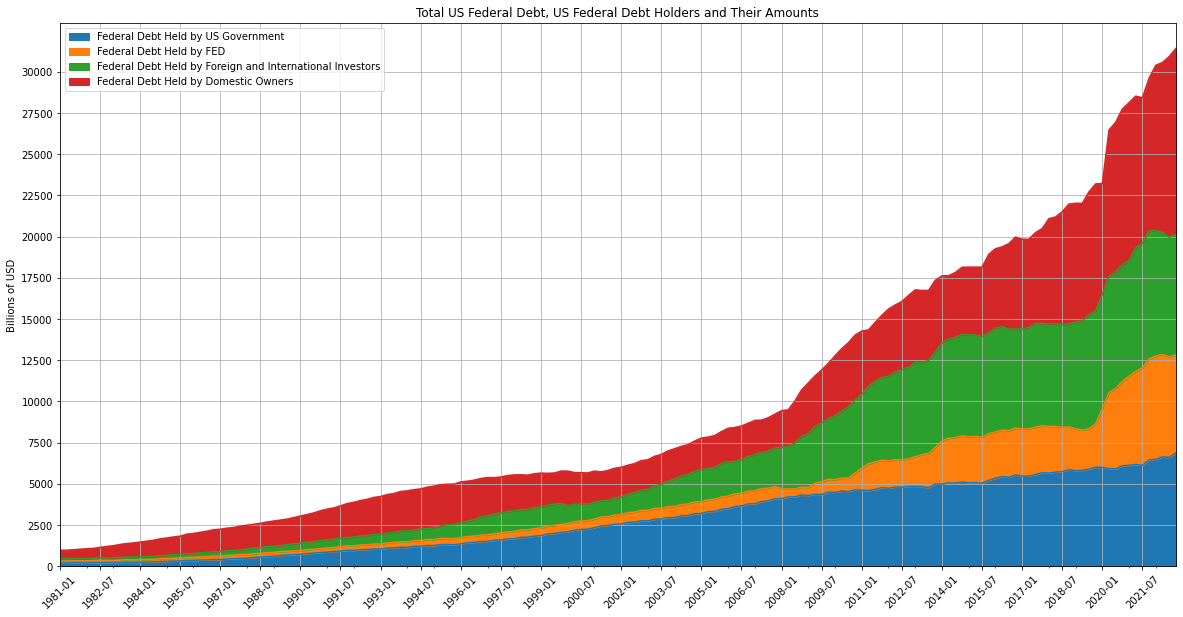

In [9]:
ax = smaller_df.plot.area(figsize=(20,10), grid=True, title='Total US Federal Debt, ' + FED_DEBT_HOLDERS_TITLE,
                          xticks=fred_pub_debt_holders.index[::6], xlabel='', rot=45,
                          ylabel=LEFT_Y_AXIS_LABEL, yticks=np.arange(0, 32000e3, 2500e3))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: "%.0f" % (x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, fred_pub_debt_holders.index[::6])))

#### Visualization of Ownership as Percent of Total Federal Debt

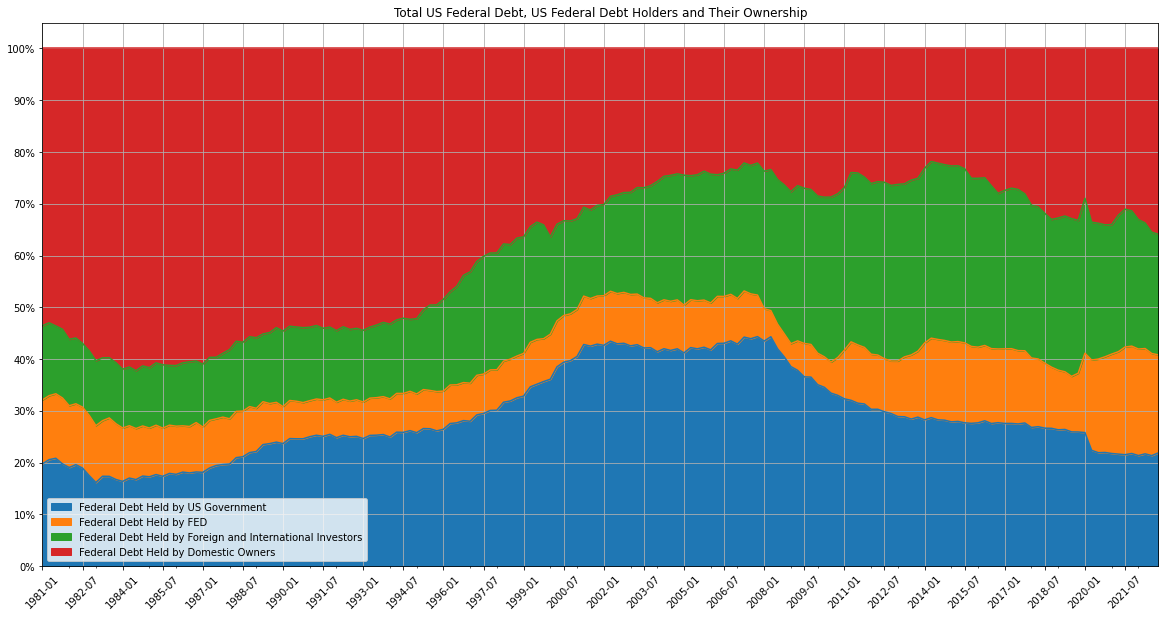

In [10]:
# Converting to percentages by dividing by total federal debt.
# Dividing by a sum of FYGFDPUN and FDHBATN instead of by GFDEBTN because of a small issue in the Fred's dataset
smaller_df_pct = smaller_df.divide(fred_pub_debt_holders.iloc[:, 1:3].sum(axis=1), axis=0)

ax = smaller_df_pct.plot.area(figsize=(20,10), grid=True, title='Total US Federal Debt, ' + FED_DEBT_HOLDERS_PERCENTAGE_TITLE,
                              xticks=fred_pub_debt_holders.index[::6], xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, fred_pub_debt_holders.index[::6])))

Let's look at ownership over the past 8 quarters.

In [11]:
PCNT_FORMAT = '{:.4%}'.format

# The last 4 years
smaller_df_pct.tail(16).style.format_index(IDX_FORMAT).format(PCNT_FORMAT).set_table_styles(
    [{'selector':'.index_name.level0', 'props': [('min-width', '78px')]}])

,Federal Debt Held by US Government,Federal Debt Held by FED,Federal Debt Held by Foreign and International Investors,Federal Debt Held by Domestic Owners
DATE,,,,
2019-01,26.3486%,11.5157%,29.3900%,32.7457%
2019-04,26.4201%,11.1372%,30.0859%,32.3568%
2019-07,25.9400%,10.7240%,30.4740%,32.8620%
2019-10,25.9208%,11.3671%,29.4991%,33.2130%
2020-01,25.8142%,15.3272%,29.9240%,28.9346%
2020-04,22.3923%,17.4314%,26.6346%,33.5417%
2020-07,21.9250%,18.0846%,26.2353%,33.7551%
2020-10,21.9707%,18.4802%,25.4820%,34.0671%
2021-01,21.7744%,19.1997%,25.0183%,34.0076%


Percentage changes in the last quarter

In [13]:
df_change_last_quarter_1 = (smaller_df_pct.iloc[-1] - smaller_df_pct.iloc[-2])\
    .apply(PCNT_FORMAT).to_frame('Percentage change in ownership')

In [14]:
df_change_last_quarter_2 = (smaller_df.iloc[-1]-smaller_df.iloc[-2]).\
    apply('${:+,.0f}mn'.format).to_frame('Changes over quarter starting on {:%Y-%m-%d}'.format(fred_pub_debt_holders.index[-1]))

In [15]:
pd.concat([df_change_last_quarter_2, df_change_last_quarter_1], axis=1)

,Changes over quarter starting on 2022-10-01,Percentage change in ownership
Federal Debt Held by US Government,"$+271,742mn",0.5311%
Federal Debt Held by FED,"$-152,410mn",-0.7930%
Federal Debt Held by Foreign and International Investors,"$+63,100mn",-0.1654%
Federal Debt Held by Domestic Owners,"$+308,345mn",0.4273%


In [16]:
print('US Federal Debt changed by {:+.2f}bn in quarter starting on {:%Y-%m-%d}'
      .format((fred_pub_debt_holders.iloc[-1,0]-fred_pub_debt_holders.iloc[-2,0])/1000., fred_pub_debt_holders.index[-1].date()))

US Federal Debt changed by +490.78bn in quarter starting on 2022-10-01
